In [1]:
# install required (run once per environment)
%pip install yfinance matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf


In [3]:
sp500 = yf.Ticker("^GSPC") 

vfv = yf.Ticker("VFV.TO")

In [4]:
sp500 = sp500.history(period="max")
vfv = vfv.history(period="max")

In [5]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-07-31 00:00:00-04:00,6427.020020,6427.020020,6327.640137,6339.390137,6077080000,0.0,0.0
2025-08-01 00:00:00-04:00,6287.279785,6287.279785,6212.689941,6238.009766,5827150000,0.0,0.0
2025-08-04 00:00:00-04:00,6271.709961,6330.689941,6271.709961,6329.939941,4842580000,0.0,0.0


In [6]:
sp500.index

DatetimeIndex(['1927-12-30 00:00:00-05:00', '1928-01-03 00:00:00-05:00',
               '1928-01-04 00:00:00-05:00', '1928-01-05 00:00:00-05:00',
               '1928-01-06 00:00:00-05:00', '1928-01-09 00:00:00-05:00',
               '1928-01-10 00:00:00-05:00', '1928-01-11 00:00:00-05:00',
               '1928-01-12 00:00:00-05:00', '1928-01-13 00:00:00-05:00',
               ...
               '2025-07-24 00:00:00-04:00', '2025-07-25 00:00:00-04:00',
               '2025-07-28 00:00:00-04:00', '2025-07-29 00:00:00-04:00',
               '2025-07-30 00:00:00-04:00', '2025-07-31 00:00:00-04:00',
               '2025-08-01 00:00:00-04:00', '2025-08-04 00:00:00-04:00',
               '2025-08-05 00:00:00-04:00', '2025-08-06 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=24515, freq=None)

<Axes: title={'center': 'VFV Plot Line'}, xlabel='Date'>

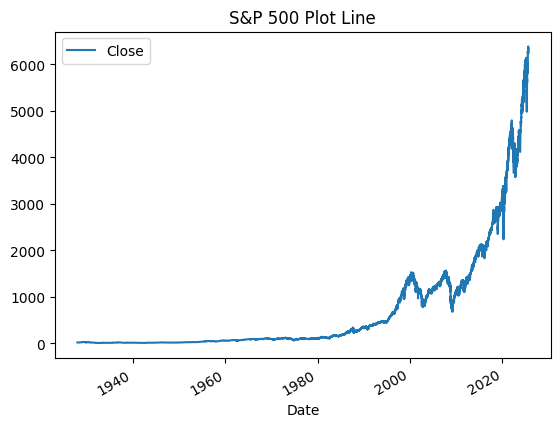

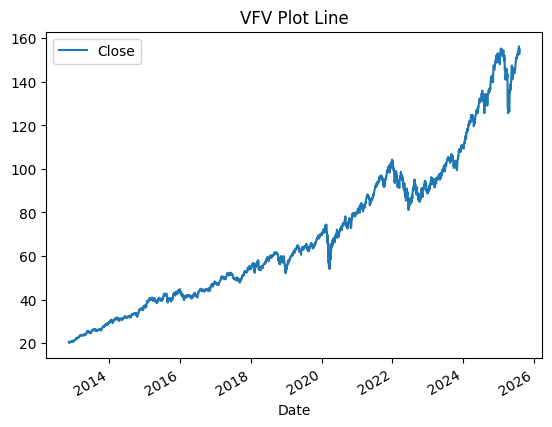

In [7]:
sp500.plot.line(y="Close", use_index=True, title="S&P 500 Plot Line")
vfv.plot.line(y="Close", use_index=True, title="VFV Plot Line")

In [8]:
del sp500["Dividends"]
del sp500["Stock Splits"]
del vfv["Dividends"]
del vfv["Stock Splits"]

In [9]:
# make column for tomorrows price (today's price shifted)
sp500["Tomorrow"] = sp500["Close"].shift(-1)
vfv["Tomorrow"] = vfv["Close"].shift(-1)

In [10]:
# target is 1 when price goes up, 0 when price goes down
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)
vfv["Target"] = (vfv["Tomorrow"] > vfv["Close"]).astype(int)

In [11]:
sp500 = sp500.loc["1990-01-01":].copy()

In [12]:
# using random forest to pick up non linear relationships and for complexity
from sklearn.ensemble import RandomForestClassifier

# using 200 trees, 100 min samples split to prevent overfitting
sp_model = RandomForestClassifier(n_estimators=200, min_samples_split=100, random_state=123)
vfv_model = RandomForestClassifier(n_estimators=200, min_samples_split=100, random_state=123)

train_sp500 = sp500.iloc[:-100]
train_vfv = vfv.iloc[:-75]

test_sp500 = sp500.iloc[-100:]
test_vfv = vfv.iloc[-100:]

features = ["Close", "Volume", "Open", "High", "Low"]

sp_model.fit(train_sp500[features], train_sp500["Target"])
vfv_model.fit(train_vfv[features], train_vfv["Target"])

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,100
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [13]:
from sklearn.metrics import precision_score

# use precision to minimize false positive (be sure when stock is actually going to increase)

sp_preds = sp_model.predict(test_sp500[features])
vfv_preds = vfv_model.predict(test_vfv[features])

In [14]:
import pandas as pd

sp_preds = pd.Series(sp_preds, index=test_sp500.index)
vfv_preds = pd.Series(vfv_preds, index=test_vfv.index)

In [15]:
print("S&P precision score: ", precision_score(test_sp500["Target"], sp_preds))
print("VFV precision score: ", precision_score(test_vfv["Target"], vfv_preds))


S&P precision score:  0.6129032258064516
VFV precision score:  0.5735294117647058


In [16]:
combined_sp = pd.concat([test_sp500["Target"], sp_preds], axis=1)
combined_vfv = pd.concat([test_vfv["Target"], vfv_preds], axis=1)

<Axes: title={'center': 'VFV predictions'}, xlabel='Date'>

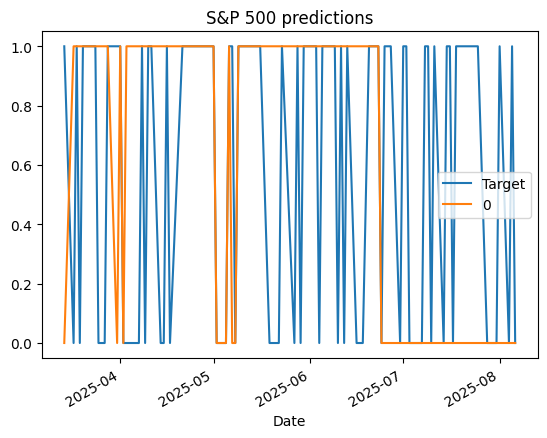

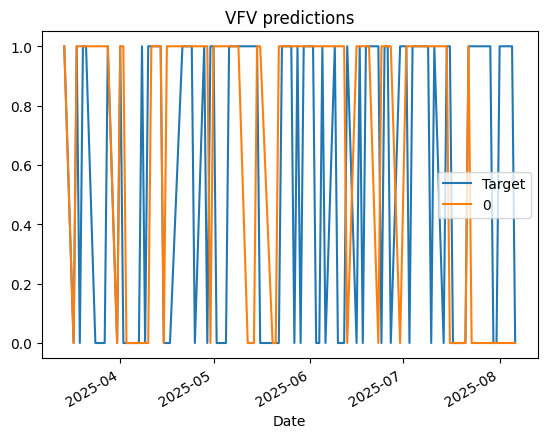

In [17]:
combined_sp.plot(title="S&P 500 predictions")
combined_vfv.plot(title="VFV predictions")

In [18]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [19]:
# train each with 10 years of data
def backtest(data, model, predictors, start=2500, step=250):
    # checking if we have enough data
    if data.shape[0] <= start:
        print(f"Warning: Dataset has {data.shape[0]} rows but start is {start}")
        start = max(int(data.shape[0] * 0.8), 500)  # use at least 500 rows for training
        print(f"Adjusted start to: {start}")
    
    all_predictions = []
    iterations = 0
    
    for i in range(start, data.shape[0], step):
        iterations += 1
        print(f"Iteration {iterations}: Training on rows 0-{i}, Testing on rows {i}-{min(i+step, data.shape[0])}")
        
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
            
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [20]:
sp_predictions = backtest(sp500, sp_model, features)
vfv_predictions = backtest(vfv, vfv_model, features)

Iteration 1: Training on rows 0-2500, Testing on rows 2500-2750
Iteration 2: Training on rows 0-2750, Testing on rows 2750-3000
Iteration 3: Training on rows 0-3000, Testing on rows 3000-3250
Iteration 4: Training on rows 0-3250, Testing on rows 3250-3500
Iteration 5: Training on rows 0-3500, Testing on rows 3500-3750
Iteration 6: Training on rows 0-3750, Testing on rows 3750-4000
Iteration 7: Training on rows 0-4000, Testing on rows 4000-4250
Iteration 8: Training on rows 0-4250, Testing on rows 4250-4500
Iteration 9: Training on rows 0-4500, Testing on rows 4500-4750
Iteration 10: Training on rows 0-4750, Testing on rows 4750-5000
Iteration 11: Training on rows 0-5000, Testing on rows 5000-5250
Iteration 12: Training on rows 0-5250, Testing on rows 5250-5500
Iteration 13: Training on rows 0-5500, Testing on rows 5500-5750
Iteration 14: Training on rows 0-5750, Testing on rows 5750-6000
Iteration 15: Training on rows 0-6000, Testing on rows 6000-6250
Iteration 16: Training on rows 0-6

In [21]:
sp_predictions["Predictions"].value_counts()

Predictions
0    3764
1    2701
Name: count, dtype: int64

In [22]:
print("S&P 500 backtested precision: ", precision_score(sp_predictions["Target"], sp_predictions["Predictions"]))

print("VFV backtested precision: ", precision_score(vfv_predictions["Target"], vfv_predictions["Predictions"]))

S&P 500 backtested precision:  0.5268419104035542
VFV backtested precision:  0.5497076023391813


In [23]:
sp_predictions["Predictions"].value_counts() / sp_predictions.shape[0]

Predictions
0    0.582212
1    0.417788
Name: count, dtype: float64

In [24]:
vfv_predictions["Predictions"].value_counts() / vfv_predictions.shape[0]

Predictions
0    0.509326
1    0.490674
Name: count, dtype: float64

This algorithm is performing just slightly better than the baseline, which is decent since it's only using market data; however, since we backtested, we have a lot more confidence in our model and our ability to test it.

In [25]:
horizons = [2,5,60,250,1000] # check last 2 days, trading week, 3 months, last year, last 4 years.

new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    rolling_averages_vfv = vfv.rolling(horizon).mean()

    ratio_column = f"Close_Ratio{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    vfv[ratio_column] = vfv["Close"] / rolling_averages_vfv["Close"]

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    vfv[trend_column] = vfv.shift(1).rolling(horizon).sum()["Target"]

    new_predictors += [ratio_column, trend_column]

In [26]:
sp500 = sp500.dropna()
vfv = vfv.dropna()

In [27]:
sp_model = RandomForestClassifier(n_estimators=200, min_samples_split=100, random_state=123)
vfv_model = RandomForestClassifier(n_estimators=200, min_samples_split=100, random_state=123)

In [28]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= 0.6] = 1 # set threshold to 60%, so model has to be more confident
    preds[preds < 0.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [29]:
sp_predictions = backtest(sp500, sp_model, new_predictors)
vfv_predictions = backtest(vfv, vfv_model, new_predictors)

Iteration 1: Training on rows 0-2500, Testing on rows 2500-2750
Iteration 2: Training on rows 0-2750, Testing on rows 2750-3000
Iteration 3: Training on rows 0-3000, Testing on rows 3000-3250
Iteration 4: Training on rows 0-3250, Testing on rows 3250-3500
Iteration 5: Training on rows 0-3500, Testing on rows 3500-3750
Iteration 6: Training on rows 0-3750, Testing on rows 3750-4000
Iteration 7: Training on rows 0-4000, Testing on rows 4000-4250
Iteration 8: Training on rows 0-4250, Testing on rows 4250-4500
Iteration 9: Training on rows 0-4500, Testing on rows 4500-4750
Iteration 10: Training on rows 0-4750, Testing on rows 4750-5000
Iteration 11: Training on rows 0-5000, Testing on rows 5000-5250
Iteration 12: Training on rows 0-5250, Testing on rows 5250-5500
Iteration 13: Training on rows 0-5500, Testing on rows 5500-5750
Iteration 14: Training on rows 0-5750, Testing on rows 5750-6000
Iteration 15: Training on rows 0-6000, Testing on rows 6000-6250
Iteration 16: Training on rows 0-6

In [30]:
sp_predictions["Predictions"].value_counts() / sp_predictions.shape[0]

Predictions
0.0    0.875
1.0    0.125
Name: count, dtype: float64

In [31]:
vfv_predictions["Predictions"].value_counts() / vfv_predictions.shape[0]

Predictions
0.0    0.897727
1.0    0.102273
Name: count, dtype: float64

In [33]:
print("S&P 500 backtested, modified precision: ", precision_score(sp_predictions["Target"], sp_predictions["Predictions"]))

print("VFV backtested, modified precision: ", precision_score(vfv_predictions["Target"], vfv_predictions["Predictions"]))

S&P 500 backtested, modified precision:  0.5797950219619327
VFV backtested, modified precision:  0.5555555555555556


the precision has slightly increased from the improved features that were created!

things to potentially add: 
* news (articles, macroeconomic info like interest rates)
* can add key stocks/sectors (tech, etc)
* try increasing resolution (hourly data, minute by minute)